In [6]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PyQuanteDriver, BasisType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType

In [12]:
driver = PySCFDriver(atom='H .0 .0 -0.5; H .0 .0 0.5',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -1.0661086493179366
Nuclear repulsion energy: 0.52917721092
Number of molecular orbitals: 2
Number of alpha electrons: 1
Number of beta electrons: 1


In [13]:
core = Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                two_qubit_reduction=False)
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Representation: paulis, qubits: 4, size: 15


In [14]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.empty(steps+1)

In [15]:
print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps 
    for j in range(len(algorithms)):
        #driver = PyQuanteDriver(atoms=molecule.format(d/2), basis=BasisType.BSTO3G)
        #qmolecule = driver.run()
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                two_qubit_reduction=False)
        qubit_op, aux_ops = operator.run(qmolecule)
        
        if algorithms[j] == 'ExactEigensolver':
            result = ExactEigensolver(qubit_op).run()
        else:
            optimizer = COBYLA(maxiter=10000)
            initial_state = HartreeFock(qubit_op.num_qubits,
                                        operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(qubit_op.num_qubits, depth=1,
                            num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
        
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)


Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05515978 -1.07591365 -1.09262989 -1.10591804 -1.116286   -1.12416091
  -1.12990477 -1.13382618 -1.13618943 -1.13722137 -1.13711706 -1.13604436
  -1.13414766 -1.1315512  -1.12836187 -1.12467174 -1.12056028 -1.11609623
  -1.11133941 -1.10634209 -1.10115031]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
Hartree-Fock energies: [-1.04299627 -1.06306214 -1.07905074 -1.0915705  -1.10112824 -1.10814999
 -1.11299655 -1.11597526 -1.11734903 -1.11734327 -1.11615145 -1.11393966
 -1.1108504  -1.10700581 -1.10251055 -1.09745432 -1.09191404 -1.08595587
 -1.07963693 -1.07300676 -1.06610865]
VQE num evalua

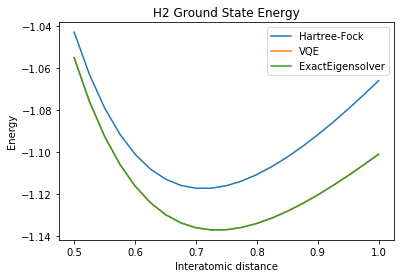

In [16]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');